#不平衡数据分类

本教程演示了如何对高度不平衡的数据集进行分类，在该数据集中，一个类中的示例数量大大超过另一类中的示例数量。您将使用Kaggle上托管的[信用卡欺诈检测](https://www.kaggle.com/mlg-ulb/creditcardfraud)数据集。目的是从总共284,807笔交易中检测到仅492笔欺诈交易。您将使用Keras定义模型和[类权重](https://www.tensorflow.org/versions/r2.0/api_docs/python/tf/keras/Model?hl=zh_cn)，以帮助模型从不平衡数据中学习。。

本教程包含完整的代码以：

* 使用pandas加载CSV文件。
* 创建训练，验证和测试集。
* 使用Keras定义和训练模型（包括设置班级权重）。
* 使用各种指标（包括精度和召回率）评估模型。
* 尝试使用常见技术处理不平衡数据，例如：
  * 班级加权
  * 过采样
  
##设定

In [1]:
try:
  %tensorflow_version 2.x
except Exception:
  pass

TensorFlow 2.x selected.


In [0]:
from __future__ import absolute_import, division, print_function, unicode_literals

In [0]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib.pyplot as plt
import matplotlib as mpl 
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


In [0]:
mpl.rcParams['figure.figsize'] = (12,10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

##数据处理与探索
###下载Kaggle信用卡欺诈数据集
Pandas是一个Python库，具有许多有用的实用程序，可用于加载和使用结构化数据，并可用于将CSV下载到数据框中。


>注意：此数据集是在Worldline与ULB 机器学习小组（University Libre de Bruxelles）在大数据挖掘和欺诈检测方面的研究合作过程中收集和分析的。有关相关主题的当前和过去项目的更多详细信息，请参见此处，以及DefeatFraud项目的页面。

In [5]:
file = tf.keras.utils
raw_df = pd.read_csv('https://storage.googleapis.com/download.tensorflow.org/data/creditcard.csv')
raw_df.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
raw_df[['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V26', 'V27', 'V28', 'Amount', 'Class']].describe()

,Time,V1,V2,V3,V4,V5,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


###检查班级标签不平衡
让我们看一下数据集的不平衡：

In [7]:
neg, pos = np.bincount(raw_df['Class'])
total = neg + pos

print('Example:\n Total: {}\n Positive: {} ({:.2f}% of total\n'.format(total,pos, 100* pos/total))

Example:
 Total: 284807
 Positive: 492 (0.17% of total



这表明阳性样品的比例很小。

###清理，拆分和规范化数据
原始数据有一些问题。首先，`Time`和`Amount`列的变量太大，无法直接使用。删除该`Time`列（因为尚不清楚其含义），并获取该`Amount`列的日志以缩小其范围。

In [0]:
cleaned_df = raw_df.copy()

#You don't want the 'Time' column.
cleaned_df.pop('Time')

#The 'Amount' column covers a huge range. Convert to lag-space.
eps=0.001 # 0 => 0.1C
cleaned_df['Log Ammount'] = np.log(cleaned_df.pop('Amount') + eps)

将数据集分为训练，验证和测试集。在模型拟合过程中使用验证集来评估损失和任何度量，但是模型不适合此数据。该测试集在训练阶段完全未使用，仅在最后用于评估模型对新数据的推广程度。这对于不平衡的数据集尤为重要，因为过度训练是缺乏训练数据的一个重要问题。

In [0]:
train_df, test_df = train_test_split(cleaned_df, test_size=0.2)
trian_df, val_df = train_test_split(train_df, test_size=0.2)

train_labels = np.array(train_df.pop('Class'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Class'))
test_labels = np.array(test_df.pop('Class'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)

使用sklearn StandardScaler标准化输入功能。这会将平均值设置为0，标准偏差设置为1。

>注：该StandardScaler是只适合使用train_features，以确保该模型是不是在验证或测试集偷看。

In [10]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

#将数据大小限制在-5和5之间
train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)

print('训练标签：', train_labels.shape)
print('验证标签：', val_labels.shape)
print('测试标签：', test_labels.shape)

print('训练数据：', train_features.shape)
print('验证数据：', val_features.shape)
print('测试数据：', test_features.shape)

训练标签： (227845,)
验证标签： (45569,)
测试标签： (56962,)
训练数据： (227845, 29)
验证数据： (45569, 29)
测试数据： (56962, 29)


###看数据分布
接下来比较一些特征上正例和负例的分布。此时要问自己的好问题是：

* 这些分布有意义吗？
  * 是。您已经对输入进行了归一化，这些输入大部分集中在+/- 2范围内。
* 您能看到分配之间的区别吗？
  * 是的，积极的例子包含更高的极值比率。

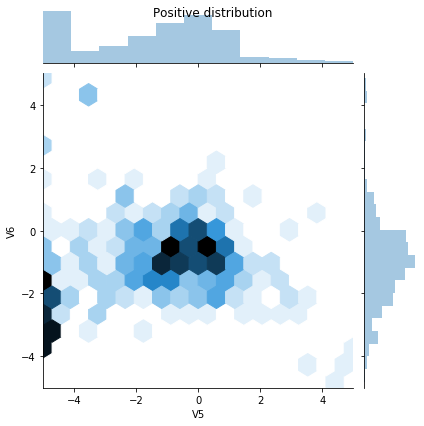

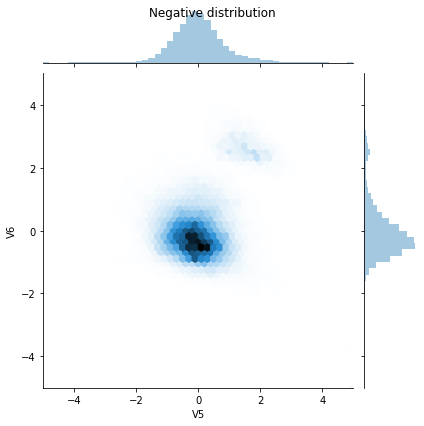

In [11]:
pos_df = pd.DataFrame(train_features[bool_train_labels], columns=train_df.columns)
neg_df = pd.DataFrame(train_features[~bool_train_labels], columns=train_df.columns)

sns.jointplot(pos_df['V5'],pos_df['V6'],
              kind='hex', xlim=(-5,5), ylim=(-5,5))
plt.suptitle("Positive distribution")

sns.jointplot(neg_df['V5'],neg_df['V6'],
              kind='hex',xlim=(-5,5),ylim=(-5,5))

_ = plt.suptitle('Negative distribution')

###定义模型和指标
定义一个函数，该函数创建一个简单的神经网络，其中包含一个紧密连接的隐藏层，一个用于减少过度拟合的辍学层以及一个输出Sigmoid层，用于返回交易被欺诈的可能性：

In [0]:
METRICS = [
  keras.metrics.TruePositives(name='tp'),
  keras.metrics.FalsePositives(name='fp'),
  keras.metrics.TrueNegatives(name='fn'),
  keras.metrics.FalseNegatives(name='tn'),
  keras.metrics.BinaryAccuracy(name='accuracy'),
  keras.metrics.Precision(name='precision'),
  keras.metrics.Recall(name='recall'),
  keras.metrics.AUC(name='auc'),
]

def make_model(metrics = METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)
      ),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer = keras.optimizers.Adam(lr=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics
  )
  return model

###了解有用的指标
请注意，上面定义了一些可以由模型计算的指标，这些指标在评估性能时会有所帮助。

* 假阴性和假阳性是分类错误的样本
* 真阴性和真阳性是正确分类的样本
* 准确度是正确分类的 >的百分比
   $\frac{\text{true samples}}{\text{total samples}}$ 
* 精确度是正确分类为的预测阳性 百分比
   $\frac{\text{true positives}}{\text{true positives + false positives}}$
*    $\frac{\text{true positives}}{\text{true positives + false negatives}}$
* AUC是指接收器工作特性曲线
（ROC-AUC）的曲线下面积。该度量等于分类器将随机正样本的排名高于随机负样本的概率。

>注意：精度不是此任务的有用指标。通过始终预测为False，您可以在此任务上达到99.8％+的准确性。

阅读更多：

* 正确与错误以及正面与负面
* 准确性
* 精确度和召回率
* 中华民国
###基准模型
####建立模型
现在，使用先前定义的功能创建并训练您的模型。请注意，该模型使用的批次大于默认的2048批次，这对于确保每个批次都有一定的机会容纳少量阳性样品非常重要。如果批量太小，则可能没有欺诈性交易可借鉴。

>注意：此模型不能很好地处理类不平衡问题。您将在本教程的后面部分中对其进行改进。

In [0]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_auc',
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True
)

In [14]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                480       
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 17        
Total params: 497
Trainable params: 497
Non-trainable params: 0
_________________________________________________________________


试运行模型：

In [15]:
model.predict(train_features[:10])

array([[0.76522964],
       [0.7645211 ],
       [0.79332215],
       [0.8456857 ],
       [0.8433728 ],
       [0.8145619 ],
       [0.79646224],
       [0.8412017 ],
       [0.8473434 ],
       [0.8564434 ]], dtype=float32)

###可选：设置正确的初始偏差。
这些是最初的猜测，并不是很好。您知道数据集不平衡。设置输出层的偏差以反映该偏差（请参阅：训练神经网络的食谱：“好好开始”）。这有助于初始收敛。

使用默认偏置初始化时，损耗应约为 math.log(2) = 0.69314

In [16]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 1.6646


可以从以下公式得出要设置的正确偏差：

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [17]:
initial_bias = np.log([pos/neg])
initial_bias

array([-6.35935934])

将其设置为初始偏差，模型将给出更合理的初始猜测。

它应该在附近： `pos/total = 0.0018`

In [18]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.00181862],
       [0.01401061],
       [0.00072751],
       [0.00120801],
       [0.00196488],
       [0.00031865],
       [0.00253872],
       [0.00260465],
       [0.00108805],
       [0.00150687]], dtype=float32)

通过此初始化，初始损耗应约为：

$$ -p_0log(p_0)-(1-p_0)log(1-p_0)=0.01317 $$

In [19]:
results = model.evaluate(train_features,train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.0127


最初的损失大约是幼稚初始化的损失的50倍。

这样，该模型就不需要花费前几个时期就可以知道不可能有积极的例子。这也使得在训练过程中更容易读取损失图。

###检查点初始重量
为了使各种训练运行具有更高的可比性，请将此初始模型的权重保留在检查点文件中，然后在进行训练之前将其加载到每个模型中。

In [0]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

###确认偏差修正有帮助
在继续之前，请迅速确认仔细的偏置初始化确实有帮助。

在进行和不进行仔细初始化的情况下，训练模型20个时间段，并比较损失：

In [0]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels),
    verbose=0
)

In [0]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data = (val_features,val_labels),
    verbose=0
)

In [0]:
def plot_loss(history,label,n):
  plt.semilogx(history.epoch, history.history['loss'],
               color=colors[n],label='Train '+label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val'+label,
               linestyle='--')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')

  plt.legend()

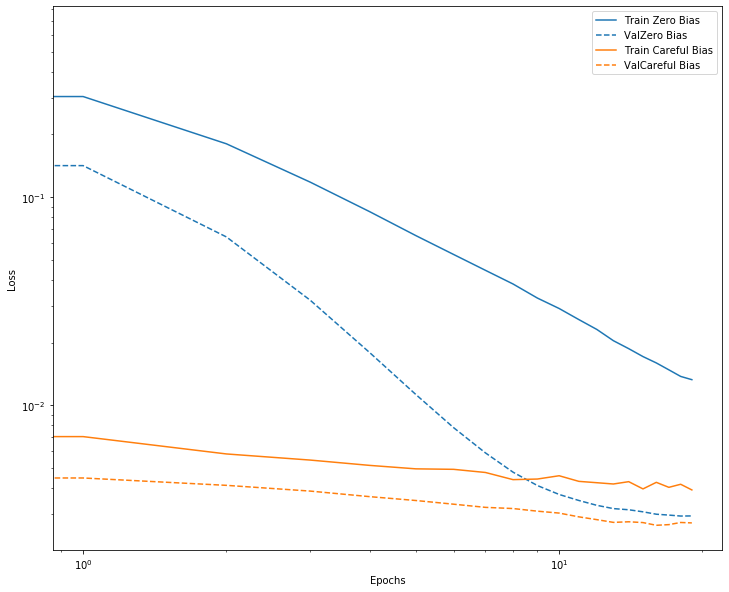

In [24]:
plot_loss(zero_bias_history,"Zero Bias ",0)
plot_loss(careful_bias_history, "Careful Bias",1)

上图清楚表明：就验证损失而言，在此问题上，这种仔细的初始化具有明显的优势。

###训练模型

In [25]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
validation_data=(val_features, val_labels)
)

Train on 227845 samples, validate on 45569 samples
Epoch 1/100
227845/227845 [==============================] - 3s 14us/sample - loss: 0.0109 - tp: 62.0000 - fp: 104.0000 - fn: 227333.0000 - tn: 346.0000 - accuracy: 0.9980 - precision: 0.3735 - recall: 0.1520 - auc: 0.8181 - val_loss: 0.0052 - val_tp: 20.0000 - val_fp: 8.0000 - val_fn: 45500.0000 - val_tn: 41.0000 - val_accuracy: 0.9989 - val_precision: 0.7143 - val_recall: 0.3279 - val_auc: 0.9084
Epoch 2/100
227845/227845 [==============================] - 1s 4us/sample - loss: 0.0068 - tp: 166.0000 - fp: 40.0000 - fn: 227397.0000 - tn: 242.0000 - accuracy: 0.9988 - precision: 0.8058 - recall: 0.4069 - auc: 0.8931 - val_loss: 0.0045 - val_tp: 35.0000 - val_fp: 11.0000 - val_fn: 45497.0000 - val_tn: 26.0000 - val_accuracy: 0.9992 - val_precision: 0.7609 - val_recall: 0.5738 - val_auc: 0.9093
Epoch 3/100
227845/227845 [==============================] - 1s 4us/sample - loss: 0.0060 - tp: 210.0000 - fp: 42.0000 - fn: 227395.0000 - tn: 19

###查看训练记录
在本部分中，您将在训练和验证集上生成模型的精度和损失图。这些对于检查过度拟合很有用，您可以在本教程中了解更多信息。

此外，您可以为您在上面创建的任何指标生成这些图。假阴性作为示例。

In [0]:
def plot_metrics(history):
  metrics = ['loss','auc','precision','recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_",' ').capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric],color=colors[0],label='Train')
    plt.plot(history.epoch,history.history['val_'+metric],
             color=colors[0],linestyle="--",label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0,plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

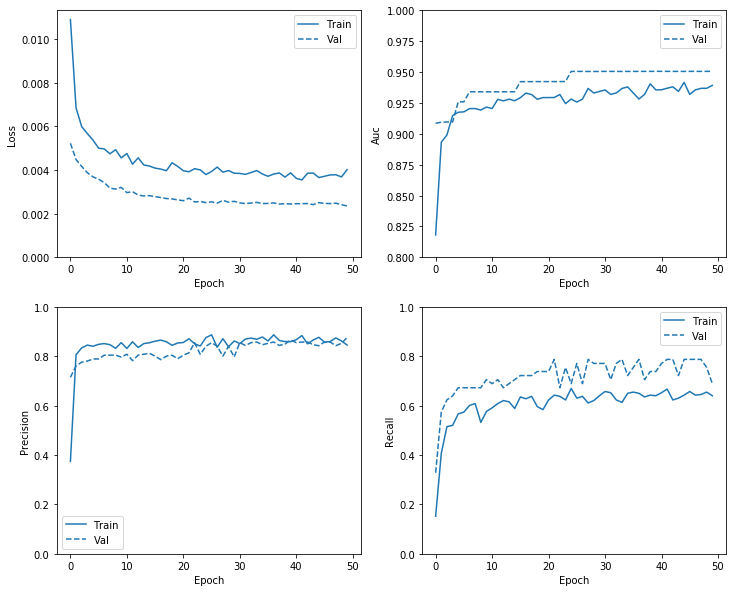

In [27]:
plot_metrics(baseline_history)

>注意：验证曲线通常比训练曲线表现更好。这主要是由于在评估模型时退出层未处于活动状态。

###评估指标
您可以使用混淆矩阵来汇总实际标签与预测标签，其中X轴为预测标签，Y轴为实际标签。

In [0]:
train_predictions_baseline = model.predict(train_features,batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features,batch_size=BATCH_SIZE)

In [0]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels,predictions>p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt='d')
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

在测试数据集上评估模型，并显示您在上面创建的指标的结果。

loss :  0.0018705741471520974
tp :  71.0
fp :  6.0
fn :  56872.0
tn :  13.0
accuracy :  0.99966645
precision :  0.9220779
recall :  0.8452381
auc :  0.9581788

Legitimate Transactions Detected (True Negatives):  56872
Legitimate Transactions Incorrectly Detected (False Positives):  6
Fraudulent Transactions Missed (False Negatives):  13
Fraudulent Transactions Detected (True Positives):  71
Total Fraudulent Transactions:  84


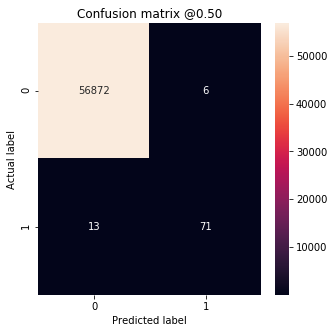

In [30]:
baseline_results = model.evaluate(test_features,test_labels,
                                  batch_size=BATCH_SIZE,verbose=0)
for name, value in zip(model.metrics_names,baseline_results):
  print(name,": ",value)
print()

plot_cm(test_labels, test_predictions_baseline)

如果模型能够完美地预测所有内容，则这将是一个对角矩阵，其中偏离主对角线的值（表示不正确的预测）将为零。在这种情况下，矩阵显示您的误报相对较少，这意味着被错误标记的合法交易相对较少。但是，尽管增加了误报数量，但您可能希望拥有更少的误报。这种权衡取舍可能是更可取的，因为误报会导致欺诈性交易通过，而误报会导致向客户发送电子邮件，要求他们验证卡的活动。

###绘制ROC
现在绘制ROC。该图非常有用，因为它一眼就能显示出只要调整输出阈值就可以达到的性能范围。

In [0]:
def plot_roc(name,labels,predictions,**kwargs):
  fp,tp,_ = sklearn.metrics.roc_curve(labels,predictions)

  plt.plot(100*fp,100*tp,label=name,linewidth=2,**kwargs)
  plt.xlabel('False positives [%]')
  plt.ylabel('True positives [%]')
  plt.xlim([-0.5,20])
  plt.ylim([80,100.5])
  plt.grid(True)
  ax = plt.gca()
  ax.set_aspect('equal')

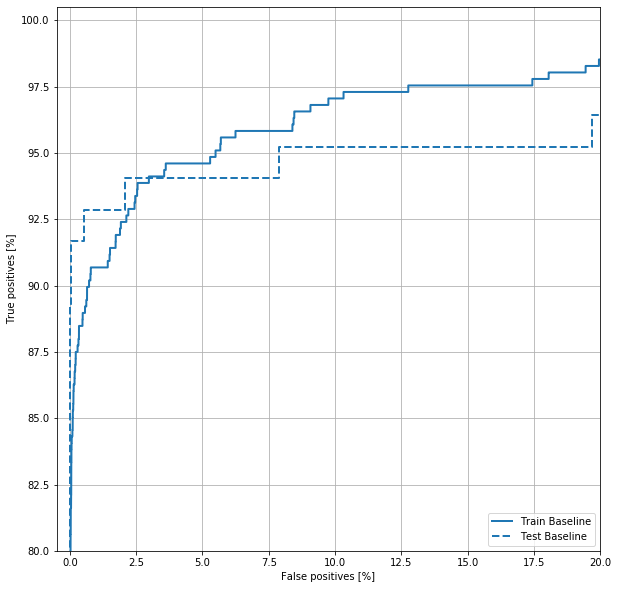

In [32]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline,color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline,color=colors[0],linestyle='--')
plt.legend(loc='lower right')

看起来精度相对较高，但是召回率和ROC曲线下的面积（AUC）并不是您所希望的那么高。当试图同时提高精度和查全率时，分类器通常会面临挑战，在处理不平衡数据集时尤其如此。在您关心的问题中考虑不同类型错误的代价很重要。在此示例中，误报（错过了欺诈性交易）可能会产生财务成本，而误报（将交易错误地标记为欺诈性）可能会降低用户满意度。

##班级重量
###计算班级权重
目标是识别重复交易，但是您没有太多可用于处理的积极样本，因此您希望分类器对可用的几个示例进行权衡。您可以通过将每个类的Keras权重传递给参数来实现。这些将导致模型“更多关注”来自代表性不足的类的示例。

In [33]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg)*(total)/2.0 
weight_for_1 = (1 / pos)*(total)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.50
Weight for class 1: 289.44


用班级重量训练模型
现在尝试使用类权重对模型进行重新训练和评估，以了解其如何影响预测。

>注意：使用class_weights更改损耗范围。根据优化程序，这可能会影响训练的稳定性。步长取决于梯度大小的优化器optimizers.SGD可能会失败。此处使用的优化optimizers.Adam程序不受缩放更改的影响。还要注意，由于加权，两个模型之间的总损失不具可比性

In [34]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight) 

  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train on 227845 samples, validate on 45569 samples
Epoch 1/100
227845/227845 [==============================] - 4s 16us/sample - loss: 1.3802 - tp: 143.0000 - fp: 678.0000 - fn: 226759.0000 - tn: 265.0000 - accuracy: 0.9959 - precision: 0.1742 - recall: 0.3505 - auc: 0.8497 - val_loss: 0.5275 - val_tp: 41.0000 - val_fp: 62.0000 - val_fn: 45446.0000 - val_tn: 20.0000 - val_accuracy: 0.9982 - val_precision: 0.3981 - val_recall: 0.6721 - val_auc: 0.8972
Epoch 2/100
227845/227845 [==============================] - 1s 5us/sample - loss: 0.6247 - tp: 284.0000 - fp: 1618.0000 - fn: 225819.0000 - tn: 124.0000 - accuracy: 0.9924 - precision: 0.1493 - recall: 0.6961 - auc: 0.9225 - val_loss: 0.3792 - val_tp: 49.0000 - val_fp: 126.0000 - val_fn: 45382.0000 - val_tn: 12.0000 - val_accuracy: 0.9970 - val_precision: 0.2800 - val_recall: 0.8033 - val_auc: 0.9273
Epoch 3/100
227845/227845 [==============================] - 1s 5us/sample - loss: 0.4390 

###查看训练记录

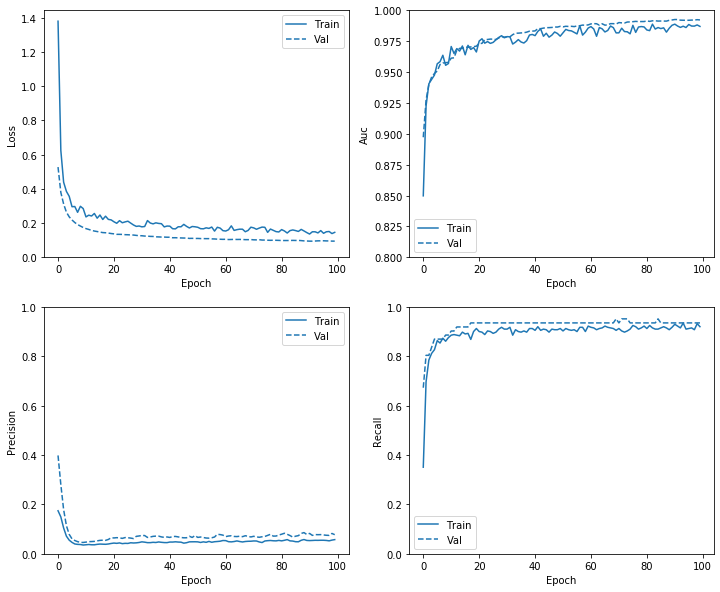

In [35]:
plot_metrics(weighted_history)

###评估指标

In [0]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.068867719525595
tp :  79.0
fp :  784.0
fn :  56094.0
tn :  5.0
accuracy :  0.98614866
precision :  0.091541134
recall :  0.9404762
auc :  0.9759378

Legitimate Transactions Detected (True Negatives):  56094
Legitimate Transactions Incorrectly Detected (False Positives):  784
Fraudulent Transactions Missed (False Negatives):  5
Fraudulent Transactions Detected (True Positives):  79
Total Fraudulent Transactions:  84


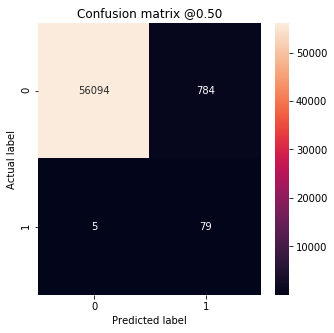

In [37]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

在这里，您可以看到，使用类权重，由于存在更多的误报，因此准确性和准确性较低，但是相反，由于模型也找到了更多的真实报错，因此召回率和AUC较高。尽管该模型准确性较低，但其召回率较高（并识别出更多的欺诈交易）。当然，两种类型的错误都有代价（您也不想通过将太多合法交易标记为欺诈来欺骗用户）。仔细考虑应用程序在这些不同类型的错误之间的权衡。

###绘制ROC

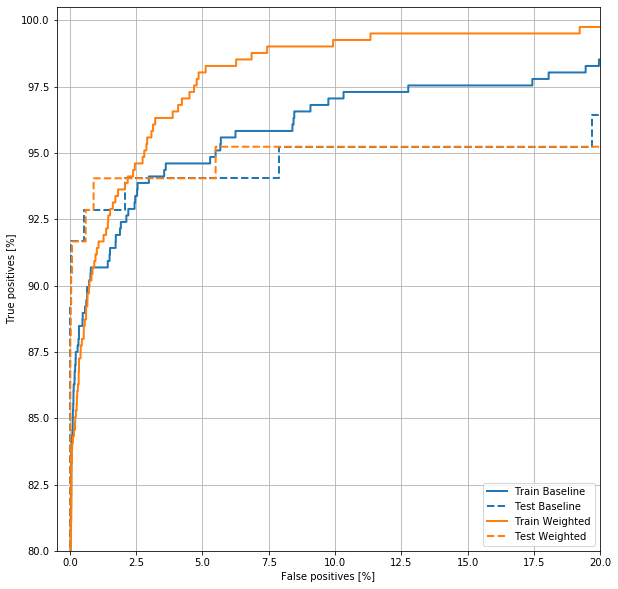

In [39]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

##过采样
###对少数族裔过度采样
一种相关的方法是通过对少数类进行过度采样来对数据集进行重新采样。

In [0]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

###使用NumPy
您可以通过从正例中选择正确数量的随机索引来手动平衡数据集：

In [41]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(227437, 29)

In [42]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(454874, 29)

###使用 tf.data
如果您要使用tf.data最简单的方法来生成平衡的示例，则从a positive和一个negative数据集开始，然后合并它们。有关更多示例，请参见tf.data指南。

In [0]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

每个数据集提供(feature, label)对：

In [44]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-1.78404162  0.15634366 -2.95550775  3.42711012 -5.          2.72279217
  4.36947372 -1.62074585 -0.70717433 -1.82713315  4.59185109 -5.
  1.46079405 -3.90175178  0.34630367 -2.29436437 -5.         -1.41321811
  2.04152404 -3.93527261 -1.4265536   0.28341845 -3.4093769   0.28261407
 -0.75699338  0.61311995  4.9316896  -2.73793283  2.25109952]

Label:  1


使用experimental.sample_from_datasets以下命令将两者合并：

In [0]:
resampled_ds = tf.data.experimental.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [46]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.49365234375


要使用此数据集，您需要每个时期的步骤数。

在这种情况下，“时期”的定义不太清楚。假设这是一次查看每个否定示例所需的批次数量：

In [47]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

278.0

###训练过采样数据
现在尝试使用重新采样的数据集训练模型，而不是使用类权重来查看这些方法的比较。

>注意：因为通过复制正例来平衡数据，所以数据集的总大小更大，并且每个纪元都需要更多的训练步骤。

In [48]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks = [early_stopping],
    validation_data=val_ds)

Train for 278.0 steps, validate for 23 steps
Epoch 1/100
278/278 [==============================] - 11s 39ms/step - loss: 0.3782 - tp: 253287.0000 - fp: 75276.0000 - fn: 209552.0000 - tn: 31229.0000 - accuracy: 0.8129 - precision: 0.7709 - recall: 0.8902 - auc: 0.9223 - val_loss: 0.2341 - val_tp: 57.0000 - val_fp: 1377.0000 - val_fn: 44131.0000 - val_tn: 4.0000 - val_accuracy: 0.9697 - val_precision: 0.0397 - val_recall: 0.9344 - val_auc: 0.9621
Epoch 2/100
278/278 [==============================] - 8s 30ms/step - loss: 0.2038 - tp: 260605.0000 - fp: 17111.0000 - fn: 267845.0000 - tn: 23783.0000 - accuracy: 0.9282 - precision: 0.9384 - recall: 0.9164 - auc: 0.9736 - val_loss: 0.1193 - val_tp: 57.0000 - val_fp: 892.0000 - val_fn: 44616.0000 - val_tn: 4.0000 - val_accuracy: 0.9803 - val_precision: 0.0601 - val_recall: 0.9344 - val_auc: 0.9802
Epoch 3/100
278/278 [==============================] - 8s 30ms/step - loss: 0.1638 - tp: 262746.0000 - fp: 11311.0000 - fn: 273701.0000 - tn: 21586

如果训练过程在每次梯度更新时都考虑整个数据集，那么这种过度采样将与类加权基本相同。

但是，当按批次进行模型训练时（如您在此处所做的那样），过采样的数据会提供更平滑的梯度信号：与其将每个正例显示为具有较大权重的批次，不如将它们分别显示为许多不同的批次，重量轻。

这种更平滑的梯度信号使训练模型变得更加容易。

###查看训练记录
请注意，此处的指标分布将有所不同，因为训练数据与验证数据和测试数据的分布完全不同。

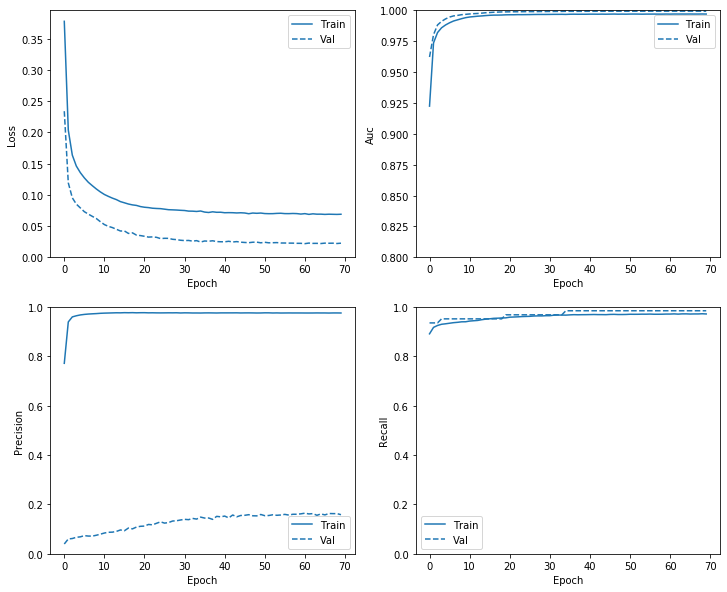

In [49]:
plot_metrics(resampled_history )

###再培训
由于在平衡数据上进行训练更容易，因此上述训练过程可能会很快过拟合。

因此，打破纪元可以callbacks.EarlyStopping更好地控制何时停止训练。

In [50]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch = 20,
    epochs=10*EPOCHS,
    callbacks = [early_stopping],
    validation_data=(val_ds))

Train for 20 steps, validate for 23 steps
Epoch 1/1000
20/20 [==============================] - 3s 170ms/step - loss: 0.6672 - tp: 16499.0000 - fp: 12287.0000 - fn: 8078.0000 - tn: 4096.0000 - accuracy: 0.6000 - precision: 0.5732 - recall: 0.8011 - auc: 0.7471 - val_loss: 0.8209 - val_tp: 53.0000 - val_fp: 27427.0000 - val_fn: 18081.0000 - val_tn: 8.0000 - val_accuracy: 0.3979 - val_precision: 0.0019 - val_recall: 0.8689 - val_auc: 0.8604
Epoch 2/1000
20/20 [==============================] - 1s 37ms/step - loss: 0.5423 - tp: 18208.0000 - fp: 11027.0000 - fn: 9425.0000 - tn: 2300.0000 - accuracy: 0.6746 - precision: 0.6228 - recall: 0.8878 - auc: 0.8569 - val_loss: 0.7194 - val_tp: 52.0000 - val_fp: 21662.0000 - val_fn: 23846.0000 - val_tn: 9.0000 - val_accuracy: 0.5244 - val_precision: 0.0024 - val_recall: 0.8525 - val_auc: 0.8834
Epoch 3/1000
20/20 [==============================] - 1s 37ms/step - loss: 0.4852 - tp: 18176.0000 - fp: 9555.0000 - fn: 11069.0000 - tn: 2160.0000 - accurac

##重新检查训练记录

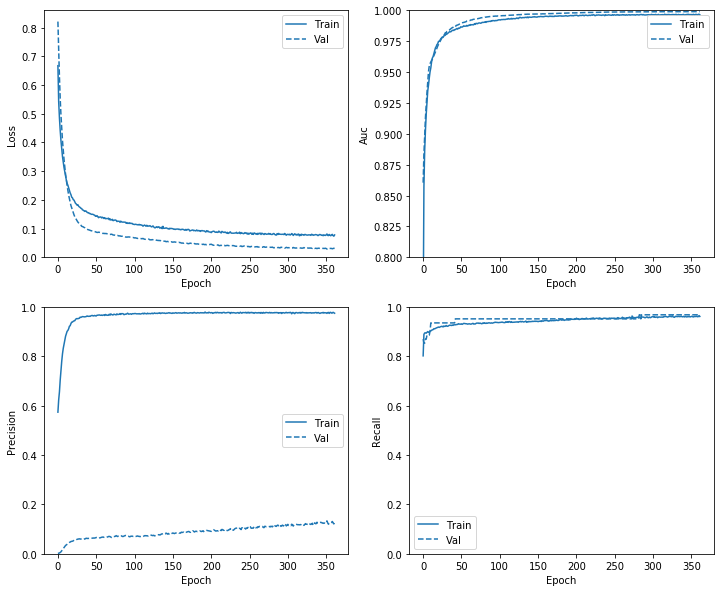

In [51]:
plot_metrics(resampled_history)

###评估指标

In [0]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.025859085088648395
tp :  79.0
fp :  467.0
fn :  56411.0
tn :  5.0
accuracy :  0.99171376
precision :  0.14468865
recall :  0.9404762
auc :  0.9678223

Legitimate Transactions Detected (True Negatives):  56094
Legitimate Transactions Incorrectly Detected (False Positives):  784
Fraudulent Transactions Missed (False Negatives):  5
Fraudulent Transactions Detected (True Positives):  79
Total Fraudulent Transactions:  84


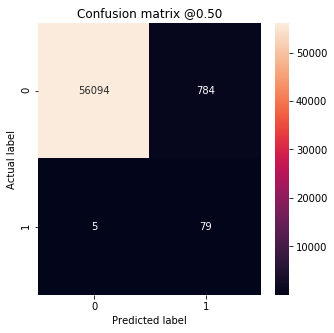

In [53]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

###绘制ROC

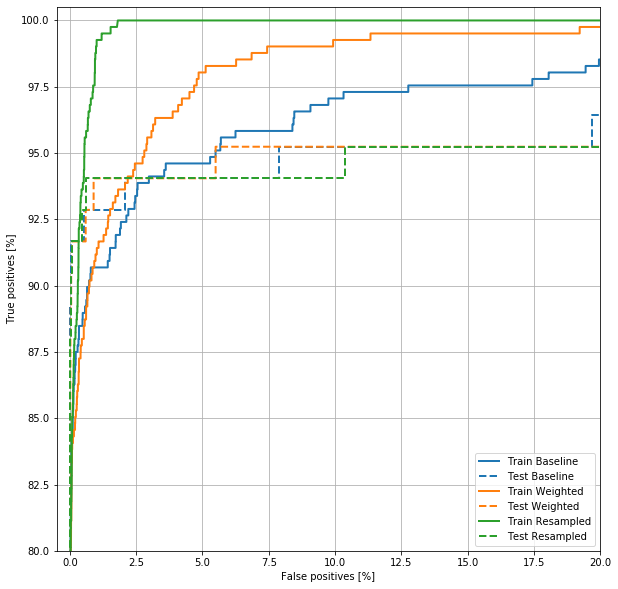

In [54]:
plot_roc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_roc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_roc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_roc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_roc("Train Resampled", train_labels, train_predictions_resampled,  color=colors[2])
plot_roc("Test Resampled", test_labels, test_predictions_resampled,  color=colors[2], linestyle='--')
plt.legend(loc='lower right')

###将本教程应用于您的问题
数据分类失衡是一项固有的难题，因为要学习的样本很少。您应该始终先从数据开始，并尽最大努力收集尽可能多的样本，并充分考虑哪些功能可能相关，以便模型可以从您的少数群体中获得最大收益。在某些时候，您的模型可能难以改善并无法获得所需的结果，因此务必牢记问题的背景以及不同类型的错误之间的权衡取舍。